In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
QiskitRuntimeService.save_account(
token="QSVF4eYHt90Tq-y2A46mzkXxJxVOOfGEOFQgZXu910UD", # Use the 44-character API_KEY you created and saved from the IBM Quantum Platform Home dashboard
instance="crn:v1:bluemix:public:quantum-computing:us-east:a/4294337f3cef478f916e1cd2358d82b2:ccd2ed50-8403-4c53-b618-64eaec4b8220::", # Optional
overwrite=True
)

In [9]:
# General imports
import numpy as np
from qiskit.quantum_info import SparsePauliOp

# Hamiltonian obtained from a previous lesson
 
H = SparsePauliOp(
    [
        "IIII",
        "IIIZ",
        "IZII",
        "IIZI",
        "ZIII",
        "IZIZ",
        "IIZZ",
        "ZIIZ",
        "IZZI",
        "ZZII",
        "ZIZI",
        "YYYY",
        "XXYY",
        "YYXX",
        "XXXX",
    ],
    coeffs=[
        -0.09820182 + 0.0j,
        -0.1740751 + 0.0j,
        -0.1740751 + 0.0j,
        0.2242933 + 0.0j,
        0.2242933 + 0.0j,
        0.16891402 + 0.0j,
        0.1210099 + 0.0j,
        0.16631441 + 0.0j,
        0.16631441 + 0.0j,
        0.1210099 + 0.0j,
        0.17504456 + 0.0j,
        0.04530451 + 0.0j,
        0.04530451 + 0.0j,
        0.04530451 + 0.0j,
        0.04530451 + 0.0j,
    ],
)
 
nuclear_repulsion = 0.7199689944489797

5


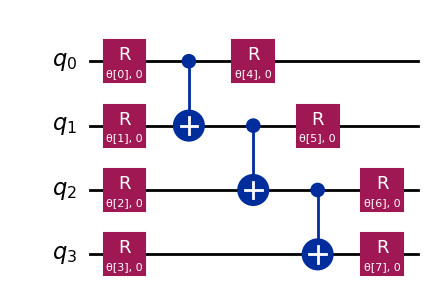

In [10]:
# Pre-defined ansatz circuit
from qiskit.circuit.library import efficient_su2
 
# SciPy minimizer routine
from scipy.optimize import minimize
 
# Plotting functions
 
# Random initial state and efficient_su2 ansatz
ansatz = efficient_su2(H.num_qubits, su2_gates=["rx"], entanglement="linear", reps=1)
x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
print(ansatz.decompose().depth())
ansatz.decompose().draw("mpl")

In [11]:
def cost_func(params, ansatz, H, estimator):
    pub = (ansatz, [H], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]
    return energy
 
 
# def cost_func_sim(params, ansatz, H, estimator):
#    energy = estimator.run(ansatz, H, parameter_values=params).result().values[0]
#    return energy

In [12]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService(channel="ibm_quantum_platform")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_marrakesh'

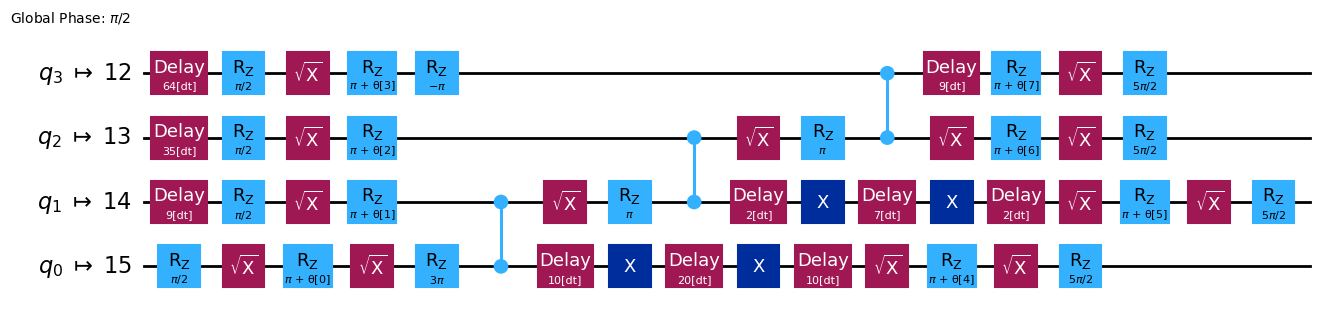

In [14]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
    ConstrainedReschedule,
)
from qiskit.circuit.library import XGate
 
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        ConstrainedReschedule(
            acquire_alignment=target.acquire_alignment,
            pulse_alignment=target.pulse_alignment,
            target=target,
        ),
        PadDynamicalDecoupling(
            target=target,
            dd_sequence=[XGate(), XGate()],
            pulse_alignment=target.pulse_alignment,
        ),
    ]
)
 
 
# Use the pass manager and draw the resulting circuit
ansatz_isa = pm.run(ansatz)
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [15]:
hamiltonian_isa = H.apply_layout(ansatz_isa.layout)
hamiltonian_isa

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIZIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIII

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit_aer import AerSimulator
from qiskit.circuit.library import TwoLocal
# Import an estimator, this time from qiskit (we will import from Runtime for real hardware)
from qiskit.primitives import BackendEstimatorV2

# generate a simulator that mimics the real quantum system
backend_sim = AerSimulator.from_backend(backend)
estimator = BackendEstimatorV2(backend=backend_sim)
res = minimize(
    cost_func,
    x0,
    args=(ansatz_isa, hamiltonian_isa, estimator),
    method="cobyla",
    options={"maxiter": 10, "disp": True},
)
 
print(getattr(res, "fun") - nuclear_repulsion)
print(res)

-1.0092461734187061
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -0.2892771789697265
       x: [ 9.074e-01  5.020e+00  6.452e+00  4.445e+00  6.871e+00
            3.043e+00  1.930e+00  2.076e+00]
    nfev: 10
   maxcv: 0.0

   NFVALS =   10   F =-2.892772E-01    MAXCV = 0.000000E+00
   X = 9.074072E-01   5.020130E+00   6.451676E+00   4.445152E+00   6.871169E+00
       3.043057E+00   1.929661E+00   2.076003E+00


In [2]:
# Load the Qiskit Runtime service
from qiskit_ibm_runtime import QiskitRuntimeService
 
# Load the Runtime primitive and session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
# Syntax for first saving your token.  Delete these lines after saving your credentials.
# QiskitRuntimeService.save_account(channel='ibm_quantum_platform', instance = '<YOUR_IBM_INSTANCE_CRN>', token='<YOUR-API_KEY>', overwrite=True, set_as_default=True)
# service = QiskitRuntimeService(channel='ibm_quantum_platform')
 
# Load saved credentials
service = QiskitRuntimeService()
 
# Use the least busy backend, or uncomment the loading of a specific backend like "ibm_brisbane".
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
# backend = service.backend("ibm_brisbane")
print(backend.name)

ibm_fez


In [3]:
# Load the Aer simulator and generate a noise model based on the currently-selected backend.
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
 
# Alternatively, load a fake backend with generic properties and define a simulator.
 
 
noise_model = NoiseModel.from_backend(backend)
 
# Define a simulator using Aer, and use it in Sampler.
backend_sim = AerSimulator(noise_model=noise_model)

In [4]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np
 
# Qubit Hamiltonian of the hydrogen atom generated by using STO-3G basis set and parity mapping
Hamiltonian = SparsePauliOp.from_list([("I", -0.2355), ("Z", 0.2355)])
 
# exact ground state energy of Hamiltonian
 
A = np.array(Hamiltonian)
eigenvalues, eigenvectors = np.linalg.eig(A)
print(
    "The exact ground state energy of the Hamiltonian is ",
    min(eigenvalues).real,
    "hartree",
)
h = min(eigenvalues.real)

The exact ground state energy of the Hamiltonian is  -0.471 hartree


In [5]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector, DensityMatrix, Pauli
 
theta = Parameter("θ")
phi = Parameter("φ")
lam = Parameter("λ")
 
ansatz1 = QuantumCircuit(1)
ansatz1.rx(theta, 0)
 
ansatz2 = QuantumCircuit(1)
ansatz2.rx(theta, 0)
ansatz2.rz(phi, 0)
 
ansatz3 = QuantumCircuit(1)
ansatz3.rx(theta, 0)
ansatz3.rz(phi, 0)
ansatz3.rx(lam, 0)

In [6]:
import matplotlib.pyplot as plt
 
 
def plot_bloch(bloch_vectors):
    # Extract X, Y, Z coordinates for 3D projection
    X_coords = bloch_vectors[:, 0]
    Z_coords = bloch_vectors[:, 2]
 
    # Compute Y coordinates from X and Z to approximate the full Bloch sphere projection
    Y_coords = bloch_vectors[:, 1]
 
    # Create 3D plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(X_coords, Y_coords, Z_coords, color="blue", alpha=0.6)
 
    # Labels and title
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Parameterized 1-Qubit Circuit on 3D Bloch Sphere")
 
    # Set axis limits and make them equal
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
 
    # Ensure equal aspect ratio for all axes
    ax.set_box_aspect([1, 1, 1])  # Equal scaling for x, y, z axes
 
    # Show grid
    ax.grid(True)
 
    plt.show()
 
 
num_samples = 5000  # Number of random states
theta_vals = np.random.uniform(0, 2 * np.pi, num_samples)
phi_vals = np.random.uniform(0, 2 * np.pi, num_samples)
lam_vals = np.random.uniform(0, 2 * np.pi, num_samples)

This circuit has  3 parameters


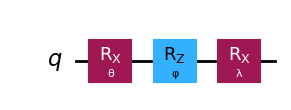

In [9]:
# Pre-defined ansatz circuit and operator class for Hamiltonian
 
ansatz = ansatz3
 
num_params = ansatz.num_parameters
print("This circuit has ", num_params, "parameters")
 
ansatz.draw("mpl", style="iqp")

Backend: {config.backend_name}
Native gates:  ['cz', 'id', 'delay', 'measure', 'reset', 'rz', 'sx', 'x', 'if_else'] ,


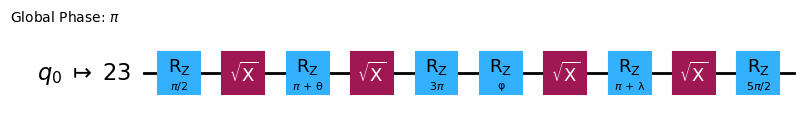

In [10]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
config = backend.configuration()
 
print("Backend: {config.backend_name}")
print("Native gates: ", config.supported_instructions, ",")
 
 
target = backend.target
 
pm = generate_preset_pass_manager(target=target, optimization_level=3)
 
ansatz_isa = pm.run(ansatz)
 
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [11]:
Hamiltonian_isa = Hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [12]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator
 
    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results
 
    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]
 
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")
 
    return energy

In [13]:
# x0 = np.random.uniform(0, 2*pi, 3)
x0 = [1, 1, 0]

In [14]:
# QPU Est. 2min for ibm_brisbane
 
from scipy.optimize import minimize
from qiskit_ibm_runtime import Batch
 
batch = Batch(backend=backend)
 
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
estimator = Estimator(mode=batch)
estimator.options.default_shots = 10000
 
res = minimize(
    cost_func,
    x0,
    args=(ansatz_isa, Hamiltonian_isa, estimator),
    method="cobyla",
    options={"maxiter": 10, "tol": 0.01},
)
 
batch.close()

Iters. done: 1 [Current cost: -0.327174113889763]
Iters. done: 2 [Current cost: -0.4647874719934743]
Iters. done: 3 [Current cost: -0.3908029954525834]
Iters. done: 4 [Current cost: -0.3807983696193271]
Iters. done: 5 [Current cost: -0.4596077032040232]
Iters. done: 6 [Current cost: -0.4641612479440064]
Iters. done: 7 [Current cost: -0.4431281465332751]
Iters. done: 8 [Current cost: -0.4679060283568598]
Iters. done: 9 [Current cost: -0.4599257300159408]
Iters. done: 10 [Current cost: -0.4619018973012852]


In [15]:
h_vqe = res.fun
print("The reference ground state energy is ", min(eigenvalues))
print("The computed ground state energy is ", h_vqe)

The reference ground state energy is  (-0.471+0j)
The computed ground state energy is  -0.4679060283568598


In [33]:
import pyscf

mol = pyscf.M(
    atom = '''O 0 0 0; H  0 1 0; H 0 0 1''',
    basis = 'sto-3g',
)

dist = 0.5
molecule = pyscf.M(
geometry=[
["H", [0.0, 0.0, -dist / 2]],
["H", [0.0, 0.0, dist / 2]]],
multiplicity=1, charge=0)
driver = ElectronicStructureMoleculeDriver(
molecule=molecule,
basis="sto3g",
driver_type=ElectronicStructureDriverType.PYSCF)
problem = ElectronicStructureProblem(driver,
[electronic.FreezeCoreTransformer(
freeze_core=True)])

TypeError: MoleBase.build() got an unexpected keyword argument 'geometry'